In [48]:
import matplotlib.pyplot as plt
import pandas as pd

from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, auc, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer

from utils import *

In [4]:
data = pd.read_csv('train.csv', index_col='id')

data['keyword'] = data.keyword.apply(lambda x: str(x))
data['location'] = data.location.apply(lambda x: str(x))

X_train, X_validation, y_train, y_validation = train_test_split(
    data.drop('target', axis=1), data.target, test_size=0.2
)

In [5]:
def get_ordinal_encoding(x):
    ordinal_encoding = np.argmax(x, axis=1)
    return ordinal_encoding


"""
def make_categorical_numeric_encoder(feature):
    categorical_numeric_encoder_ct = Pipeline(
        [
            ('t_{}_hash'.format(feature), ColumnTransformer([('t_{}'.format(feature), HashingVectorizer(), feature)])),
            ('t_{}_number'.format(feature), FunctionTransformer(get_ordinal_encoding))
        ]
    )
    return categorical_numeric_encoder_ct
"""

def make_categorical_numeric_encoder(feature):
    categorical_numeric_encoder_ct = Pipeline(
        [
            ('t_{}'.format(feature), ColumnTransformer([('t_{}'.format(feature), LeaveOneOutEncoder(), feature)])),
        ]
    )
    return categorical_numeric_encoder_ct
    

In [6]:
meta_data_encoder = ColumnTransformer(
    [
        ('mean_word_len', FunctionTransformer(lambda x: mean_word_length(x)), 'text'),
        ('tweet_length_t', FunctionTransformer(lambda x: tweet_length(x)), 'text')
    ]
)


text_encoder = Pipeline(
    [
        ('word_tokenizer', ColumnTransformer([('words', FunctionTransformer(get_words), 'text')])),
        ('stop_words_remover', FunctionTransformer(remove_stop_words)),
        ('cleaned_strings', FunctionTransformer(replace_numbers_and_punctuation)),
        ('count_vectorizer', CountVectorizer(ngram_range=(1, 1))),
        ('tfidf', TfidfTransformer(use_idf=True)),
    ]
)

keyword_encoder = make_categorical_numeric_encoder('keyword')
location_encoder = make_categorical_numeric_encoder('keyword')


In [7]:
feature_union_encoder = FeatureUnion(
    [
        ('meta_data_encoded', meta_data_encoder),
        ('text_encoded', text_encoder),
        ('keyword_encoded', keyword_encoder),
        ('location_encoded', location_encoder)
    ]
)

In [ ]:
pipeline = Pipeline([
    ('encode_data', feature_union_encoder),
    ('classify', RandomForestClassifier())
])

param_grid = {'classify': [RandomForestClassifier(), GradientBoostingClassifier(), LogisticRegression(max_iter=500), Perceptron(max_iter=500)]}
model = GridSearchCV(pipeline, param_grid)
model.fit(X_train, y_train)

In [21]:
accuracy_score(model.predict(X_validation), y_validation)

0.7905449770190414

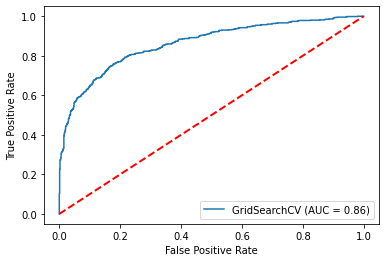

In [23]:
plot_roc_curve(model, X_validation, y_validation)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.show()

In [34]:
numeric_nb = Pipeline(
    [
        (
            'encoding', FeatureUnion(
                [
                    ('meta_data_encoded', meta_data_encoder),
                    ('text_encoded', text_encoder)
                ]
            )
        ),
        ('classify', MultinomialNB())
    ]
)

numeric_nb.fit(X_train, y_train)
print(accuracy_score(numeric_nb.predict(X_validation), y_validation))





categoric_nb = Pipeline(
    [
        (
            'data', FeatureUnion(
                [
                    ('keyword_encoded', keyword_encoder),
                    ('location_encoded', location_encoder)
                ]
            )
        ),
        ('classify', CategoricalNB())
    ]
)
categoric_nb.fit(X_train, y_train)
print(accuracy_score(categoric_nb.predict(X_validation), y_validation))

0.7918581746552856
0.5915955351280368


In [94]:
def predict_proba(X_data):
    unnormalized_joint = np.multiply(numeric_nb.predict_proba(X_data), categoric_nb.predict_proba(X_data))
    return unnormalized_joint / unnormalized_joint.sum(axis=1).reshape(-1,1)

def predict(X_data):
    label_probs = predict_proba(X_data)
    map_labels = np.argmax(label_probs, axis=1)
    return map_labels

print(accuracy_score(predict(X_validation), y_validation))

0.7642810242941562


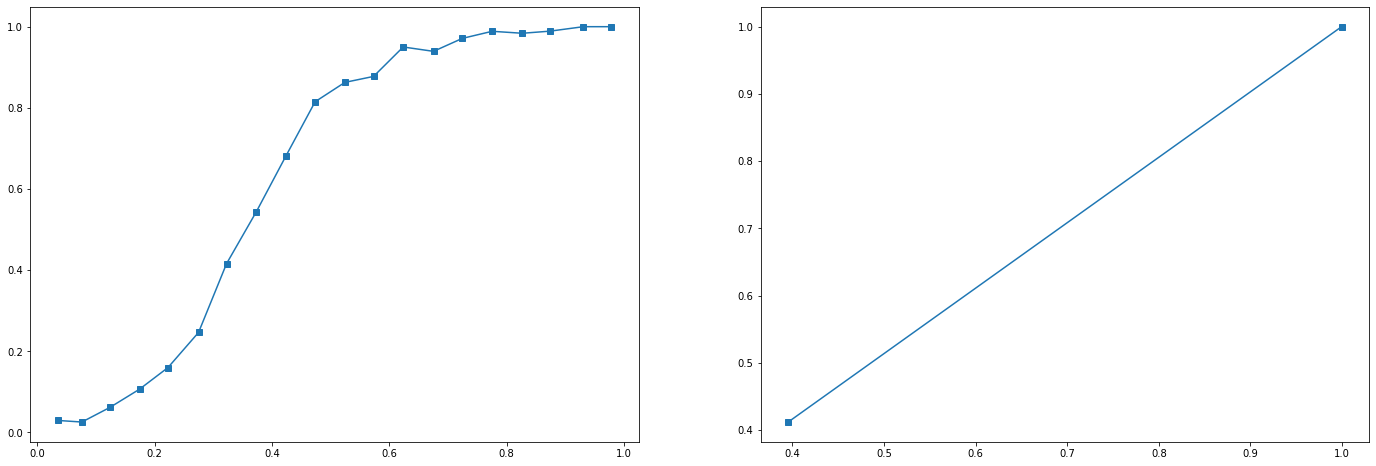

In [75]:
plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

fraction_of_positives, mean_predicted_value = calibration_curve(y_train, numeric_nb.predict_proba(X_train)[:,1].reshape(-1,1), n_bins=20)
plt.subplot(1,2,1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-")

fraction_of_positives, mean_predicted_value = calibration_curve(y_train, categoric_nb.predict_proba(X_train)[:,1].reshape(-1,1), n_bins=20)
plt.subplot(1,2,2)
plt.plot(mean_predicted_value, fraction_of_positives, "s-")


plt.show()

In [79]:
numeric_nb.fit(X_train, y_train)

array([0, 0, 1, ..., 0, 0, 0])

In [84]:
encoding_pipeline = Pipeline(
    [
        (
            'encoding', FeatureUnion(
                [
                    ('meta_data_encoded', meta_data_encoder),
                    ('text_encoded', text_encoder)
                ]
            )
        )
    ]
)
encoded_train = encoding_pipeline.fit_transform(X_train)
encoded_validation = encoding_pipeline.transform(X_validation)
isotonic = CalibratedClassifierCV(MultinomialNB(), cv=2, method='isotonic')
isotonic.fit(encoded_train, y_train)

CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                                    fit_prior=True),
                       cv=2, method='isotonic')

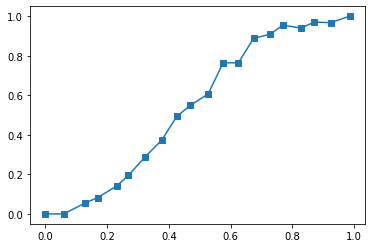

In [90]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, isotonic.predict_proba(encoded_train)[:,1].reshape(-1,1), n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.show()

In [93]:
def predict_proba(X_data, X_data_encoded):
    unnormalized_joint = np.multiply(isotonic.predict_proba(X_data_encoded), categoric_nb.predict_proba(X_data))
    return unnormalized_joint / unnormalized_joint.sum(axis=1).reshape(-1,1)

def predict(X_data, X_data_encoded):
    label_probs = predict_proba(X_data, X_data_encoded)
    map_labels = np.argmax(label_probs, axis=1)
    return map_labels

print(accuracy_score(predict(X_validation, encoded_validation), y_validation))

0.7570584372948129
